# Cifar图像分类任务

数据源：http://www.cs.toronto.edu/~kriz/cifar.html
建议下载我给大家网盘的，官网的忒慢了

In [1]:
import pickle

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

图像数据预处理下

In [2]:
import numpy as np

def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

读取数据

In [3]:
def read_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)

    data, labels = [], []
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']

    print(np.shape(data), np.shape(labels))

    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels

显示数据

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


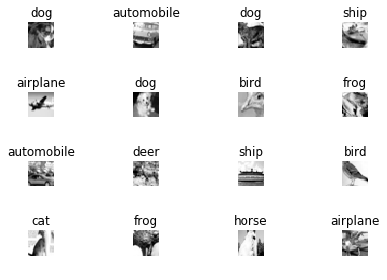

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
random.seed(1)

names, data, labels = read_data('./cifar-10-batches-py')

def show_some_examples(names, data, labels):
    plt.figure()
    rows, cols = 4, 4
    random_idxs = random.sample(range(len(data)), rows * cols)
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        j = random_idxs[i]
        plt.title(names[labels[j]])
        img = np.reshape(data[j, :], (24, 24))
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('cifar_examples.png')

show_some_examples(names, data, labels)

看看中间过程

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

names, data, labels = read_data('./cifar-10-batches-py')


def show_conv_results(data, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(data)[3]):
        img = data[0, :, :, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


def show_weights(W, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(W)[3]):
        img = W[:, :, 0, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


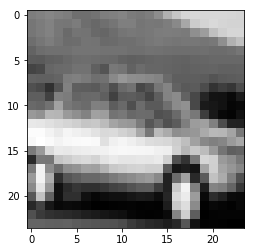

In [8]:
raw_data = data[4, :]
raw_img = np.reshape(raw_data, (24, 24))
plt.figure()
plt.imshow(raw_img, cmap='Greys_r')
plt.show()

In [9]:
x = tf.reshape(raw_data, shape=[-1, 24, 24, 1])
W = tf.Variable(tf.random_normal([5, 5, 1, 32]))
b = tf.Variable(tf.random_normal([32]))

conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)

k = 2
maxpool = tf.nn.max_pool(conv_out, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

weights:


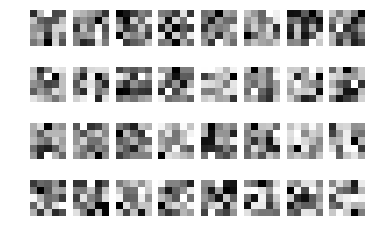

convolution results:
(1, 24, 24, 32)


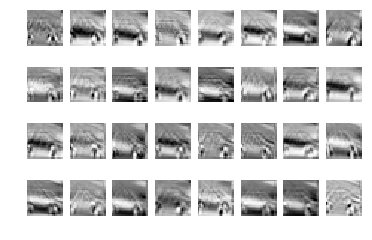

convolution with bias and relu:
(1, 24, 24, 32)


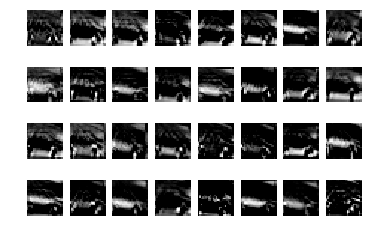

maxpool after all the convolutions:
(1, 12, 12, 32)


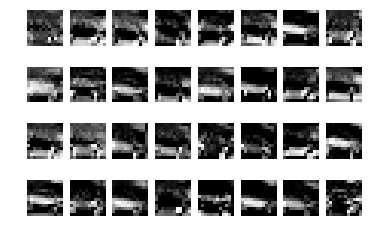

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    W_val = sess.run(W)
    print('weights:')
    show_weights(W_val)

    conv_val = sess.run(conv)
    print('convolution results:')
    print(np.shape(conv_val))
    show_conv_results(conv_val)
    

    conv_out_val = sess.run(conv_out)
    print('convolution with bias and relu:')
    print(np.shape(conv_out_val))
    show_conv_results(conv_out_val)


    maxpool_val = sess.run(maxpool)
    print('maxpool after all the convolutions:')
    print(np.shape(maxpool_val))
    show_conv_results(maxpool_val)

构建完整网络模型

In [11]:
x = tf.placeholder(tf.float32, [None, 24 * 24])
y = tf.placeholder(tf.float32, [None, len(names)])
W1 = tf.Variable(tf.random_normal([5, 5, 1, 64]))
b1 = tf.Variable(tf.random_normal([64]))
W2 = tf.Variable(tf.random_normal([5, 5, 64, 64]))
b2 = tf.Variable(tf.random_normal([64]))
W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
b3 = tf.Variable(tf.random_normal([1024]))
W_out = tf.Variable(tf.random_normal([1024, len(names)]))
b_out = tf.Variable(tf.random_normal([len(names)]))

In [12]:
def conv_layer(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_with_b = tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_with_b)
    return conv_out


def maxpool_layer(conv, k=2):
    return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [22]:
def model():
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])

    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    #提出了LRN层，对局部神经元的活动创建竞争机制，使得其中响应比较大的值变得相对更大，并抑制其他反馈较小的神经元，增强了模型的泛化能力。
    #推荐阅读http://blog.csdn.net/banana1006034246/article/details/75204013
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)

    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)

    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

In [23]:
learning_rate = 0.001
model_op = model()

cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y)
)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    onehot_labels = tf.one_hot(labels, len(names), axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = 64
    print('batch size', batch_size)
    for j in range(0, 1000):
        avg_accuracy_val = 0.
        batch_count = 0.
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size, :]
            batch_onehot_vals = onehot_vals[i:i+batch_size, :]
            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x: batch_data, y: batch_onehot_vals})
            avg_accuracy_val += accuracy_val
            batch_count += 1.
        avg_accuracy_val /= batch_count
        print('Epoch {}. Avg accuracy {}'.format(j, avg_accuracy_val))

batch size 64
Epoch 0. Avg accuracy 0.2269221547314578
Epoch 1. Avg accuracy 0.27775335677749363
Epoch 2. Avg accuracy 0.30131074168797956
Epoch 3. Avg accuracy 0.31685581841432225
Epoch 4. Avg accuracy 0.3283048273657289
Epoch 5. Avg accuracy 0.3420915920716113
Epoch 6. Avg accuracy 0.3514825767263427
Epoch 7. Avg accuracy 0.35897538363171355
Epoch 8. Avg accuracy 0.36578884271099743
Epoch 9. Avg accuracy 0.3747202685421995
Epoch 10. Avg accuracy 0.3790361253196931
Epoch 11. Avg accuracy 0.38704843350383633
Epoch 12. Avg accuracy 0.3978980179028133
Epoch 13. Avg accuracy 0.40287324168797956
Epoch 14. Avg accuracy 0.40133471867007675
Epoch 15. Avg accuracy 0.41210437979539644
Epoch 16. Avg accuracy 0.4132832480818414
Epoch 17. Avg accuracy 0.4186580882352941
Epoch 18. Avg accuracy 0.42387308184143224
Epoch 19. Avg accuracy 0.42059622762148335
Epoch 20. Avg accuracy 0.43150575447570333
Epoch 21. Avg accuracy 0.43492247442455245
Epoch 22. Avg accuracy 0.4304267902813299
Epoch 23. Avg acc

Epoch 194. Avg accuracy 0.6101942135549873
Epoch 195. Avg accuracy 0.6190856777493606
Epoch 196. Avg accuracy 0.6200447570332481
Epoch 197. Avg accuracy 0.62971547314578
Epoch 198. Avg accuracy 0.641803868286445
Epoch 199. Avg accuracy 0.649796195652174
Epoch 200. Avg accuracy 0.6583479859335039
Epoch 201. Avg accuracy 0.6653812340153452
Epoch 202. Avg accuracy 0.6691975703324808
Epoch 203. Avg accuracy 0.6661005434782609
Epoch 204. Avg accuracy 0.6631633631713555
Epoch 205. Avg accuracy 0.6632632672634271
Epoch 206. Avg accuracy 0.6560901534526854
Epoch 207. Avg accuracy 0.6543318414322251
Epoch 208. Avg accuracy 0.6455402813299232
Epoch 209. Avg accuracy 0.6297354539641944
Epoch 210. Avg accuracy 0.6272778132992327
Epoch 211. Avg accuracy 0.6212436061381074
Epoch 212. Avg accuracy 0.6176670396419437
Epoch 213. Avg accuracy 0.6185262148337596
Epoch 214. Avg accuracy 0.6258991368286445
Epoch 215. Avg accuracy 0.6306745524296675
Epoch 216. Avg accuracy 0.640744884910486
Epoch 217. Avg a